# Introduction

In this tutorial, we will try to classify images using a bag-of-features approach. First, we will go through an example in a structured environment and try to classify images of racehorses and abbeys. Next, we will expand the problem to include classifying marine images. Namely we will try to classify images with seaweed-like objects in them. Through this tutorial, you will learn concepts such as detecting features, finding saliency of an image ... Lets begin!

## Part I.

In this pset folder, you will find two folders with images in them. In the folder abbey, there are 128x128 pictures of abbeys and in the folder racehorse, there are 128x128 pictures of racehorses. There are 18 pictures of racehorses and 21 pictures of abbeys. We will try to classify these images by constructing a feature vector for each of them. The first thing we need to do is find points of interest in these images. Here, we make the design choice to use the function goodFeaturesToTrack from OpenCV to get the features of interest and plot them in the image. We can see here that the function recognizes corners and edges, which are good features because they are invariant to size or illumination changes in the image (this is important for SIFT). 

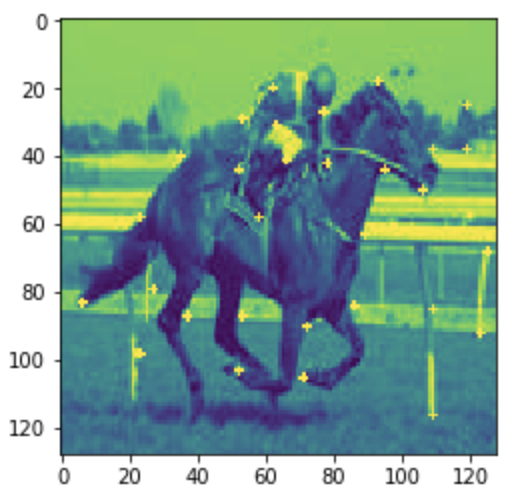

Now that we have our points of interest, or features, we need to extract the feature descriptors for each point. A popular method to do so is SIFT, and that is what we will be using here. SIFT operates on a portion or "patch" of the image, and returns a 128 length vector describing that patch.  In this example, we will be using a patch_size of 32. We will look at 31 features in each image, and get a 128 SIFT descriptor for each feature and concatenate them together to get one vector of length 3968 (31\*128) for each image. Then we will have a 36 x 3968 numpy array (because we have 36 pictures total, each with 3968 features) which we will then feed into a KMeans algorithm that will automatically cluster the pictures. We will then fit the original images to see how the KMeans algorithm clusters the pictures, and judge the accuracy of the classification method on how well it does. The pseudocode is below but the actual code can be found in the tutorial.

```
PSEUDOCODE

for every directory
    for every file
        read in the image and transform to black and white
        get good features to track and store in variable 'corner'
        
        while length is in range 31
            get a good feature from corner
            take a patch around the feature and get SIFT descriptor
            append SIFT descriptor to variable 'sift_pictures'

return sift_pictures
            
```

Then we can input the feature vectors in sift_pictures into a kmeans algorithm (the function we are using is implemented through sklearn). The function fit() takes in the feature vectors and creates clusters. Then, we can use the function predict() to enter in more feature vectors and get a prediction of their classification. When we run this on our original images and a test set we get an accuracy of 30/36 and 5/6 respectively. To see a full implementation of this, see the tutorial.

## Part II.

OK, now lets turn to image classification in unstructured environments, marine images. We will try to classify pictures of seaweed from just regular pictures of sand. To get more of a feel for these kinds of images, feel free to look through the sand and seaweed image folders. First, lets go back to the object detection we first looked at and try to apply it to our new marine image.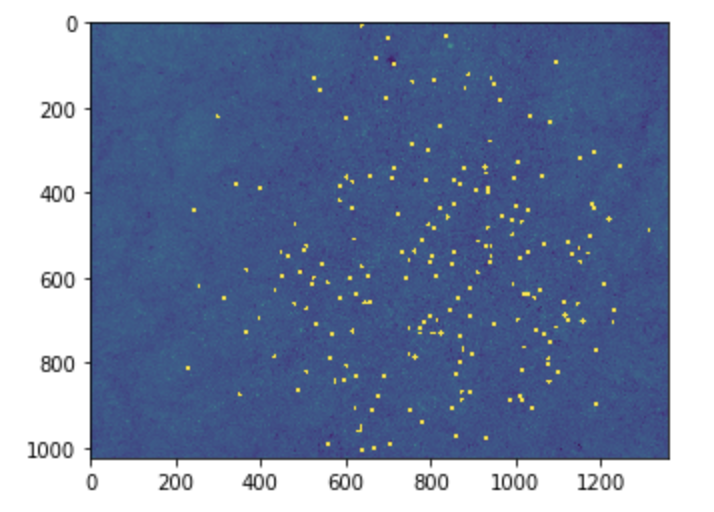

We notice that the corner detector has a harder time finding features in this situation because the image is cluttered with extra objects--the seaweed is not the focus of the image like the abbey or racehorses were. There are also fewer well-defined 'corners' in this image, further complicating the issue. We see these issues crop up if we try to run our algorithm from before on our new images. In this case there are 6 seaweed images and 5 sand images. 

When we try to rerun our code from above to classify it we find that everything is being classified to the same cluster. Now, we will attempt to fix this through two methods- one involving hue and the other entropy.

### Hue

To try and alleviate this issue, we will add extra features to our feature vector in addition to using the ones that SIFT gives us. One feature we will be using will be hue, which has been proven to be important for marine image classification from preliminary tests. For the hue value, we will convert the image into HSV space, then pull out the H values only. Then whenever we get a patch, we take the average value over all the hue values in that patch, and this becomes our extra features. We could just append this to our feature vector and have 129 features, but we want this new feature to be weighted more equally with the existing SIFT features, so we will add it 150 times to our feature vector, and the new total size of the vector will be 278. The pseudocode goes through the general process, see the implementation for the code.

```
PSEUDOCODE

for every directory
    for every file
        read in the image and transform to black and white
        get good features to track and store in variable 'corner'
        
        while length is in range 31
            get a good feature from corner
            take a patch around the feature and get SIFT descriptor
            get the hue value of the patch around the feature
            append the hue value to the SIFT descriptor 150 times
            append SIFT descriptor to variable 'sift_pictures'
            

return sift_pictures
            
```

This time we get a much better classification result.

### Entropy

Another useful feature in unstructured environments is a saliency measure. This looks at the entropy in a certain part of the image. If this portion of the image has a high entropy, that means that there is a busy region with lots of different parts that is more useful to us. In contrast, if it is a low entropy region, this means that it is a uniform area, not of as much interest. The equations for calculating entropy are below and are used in the following code after the corner detection algorithm has returned regions of interest. We then want to look at these regions of interest, and find the highest entropy ones to use as our top features. 

The entropy function is typically defined as

$$E(\Delta I)=H=-\sum_{i=1}^{n}p(x_{i})\log p(x_{i})$$

For the gray scale image we define the probability $p(x)$ as follows,

$$p(x_{i})={h(x_{i\over N})={1\over N}\sum_{j=1}^{N}\delta(x_{i}-x_{j})}$$

where $\delta$ is the discrete Dirac delta function:
$$\delta(x)=\cases{1, x=0\cr 0, x\neq 0 } $$

So finally the entropy of a patch with $N_p$ pixels will be:
$$H_{g}=-{1\over N_{p}}\sum_{j=1}^{N_{p}}\log p_{g}(x_{j}) $$
It is important to note that we are calculating the log probability, $p_{g}$ using all the pixels in the image, but the outermost sum is just over the pixels in the patch.




```
PSEUDOCODE FOR ENTROPY FUNCTION (GET_MAX)
for each feature in corner
    entropy = 0
    for each pixel in the patch size
        figure out how many pixels in the entire image have the same pixel value and add this number to entropy
        take -log(entropy) and divide by the total number of pixels and total number of pixels in the patch
    return the points with 'value' highest entropies


PSEUDOCODE FOR ENTROPY FUNCTION (GET_MAX)
for every directory
    for every file
        read in the image and transform to black and white
        get good features to track and store in variable 'corner'
        
        get the points with the highest entropies from get_max
            take a patch around the feature and get SIFT descriptor
            append SIFT descriptor to variable 'sift_pictures'
            

return sift_pictures
            
```

